In [1]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy import signal, interpolate
import numpy as np
import colorcet as cc

from gab_sound import correlation_array, filtered_array, plot_spectr, smooth, butter_lowpass_filter, butter_bandpass_filter

In [2]:
# colormaps
def get_col_peaks_freq_ampl(i):
    return cc.cm.glasbey_hv(i)


In [3]:
# record sound
"""import sounddevice as sd
from scipy.io.wavfile import write

fs = 44100  # Sample rate
seconds = 600  # Duration of recording

myrecording = sd.rec(int(seconds * fs), samplerate=fs, channels=2)
sd.wait()  # Wait until recording is finished
write('output.wav', fs, myrecording)  # Save as WAV file 
"""
pass

In [4]:
# read sound
import sounddevice as sd
import soundfile as sf

filename = 're'
data, fs = sf.read(filename, dtype='float32')  
time = [i/float(fs) for i in range(len(data))]
total_time = len(time)/fs
#print('time domain: ',data.shape, len(time), fs, 
print('one step is', 1/fs, 'seconds; total time is ', total_time )
f, t, Sxx = signal.spectrogram(data, fs)


print('frequency domain: one step is', len(time)/fs/len(t), 'seconds (sampling frequency = ', 1/(len(time)/fs/len(t)), ')' )


# now clean data: remove values that are too high and 
all_vals = sorted(Sxx.reshape(Sxx.size))
max_useful_value = all_vals[-int(Sxx.size/10000)]
#Sxx = np.vectorize(lambda x: min(x, max_useful_data))(Sxx)


freq_amplitude = np.average(Sxx, axis=1)

fit_of_sound = interpolate.interp1d(time, data, kind='cubic', assume_sorted=True)
data_short = fit_of_sound(t)

one step is 2.2675736961451248e-05 seconds; total time is  47.546122448979595
frequency domain: one step is 0.005079713936856794 seconds (sampling frequency =  196.86147929400454 )


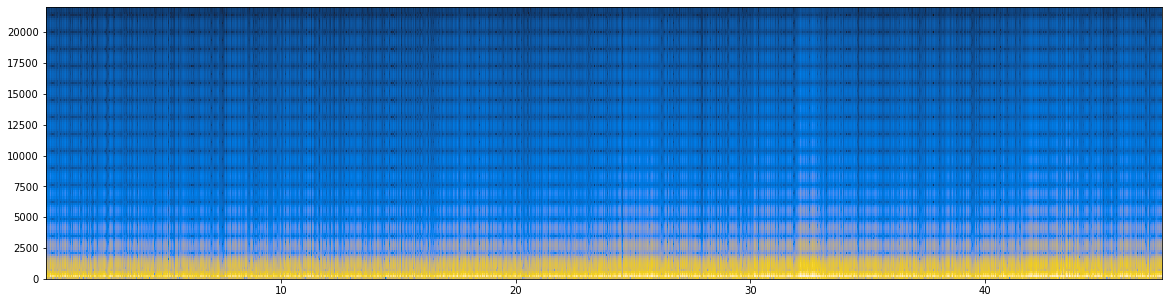

In [5]:
def plot_filtered_low(lowcut):
    low_data = butter_lowpass_filter(data, lowcut, fs=fs, order=5)
    f, t, Sxx = signal.spectrogram(low_data, fs)
    plt.figure(figsize=(20, 5))
    plt.pcolormesh(t, f, Sxx, norm=matplotlib.colors.LogNorm(), cmap=cc.cm.CET_CBL2)#, vmax=max_useful_value)
    plt.show()
    return low_data  

low = plot_filtered_low(200)


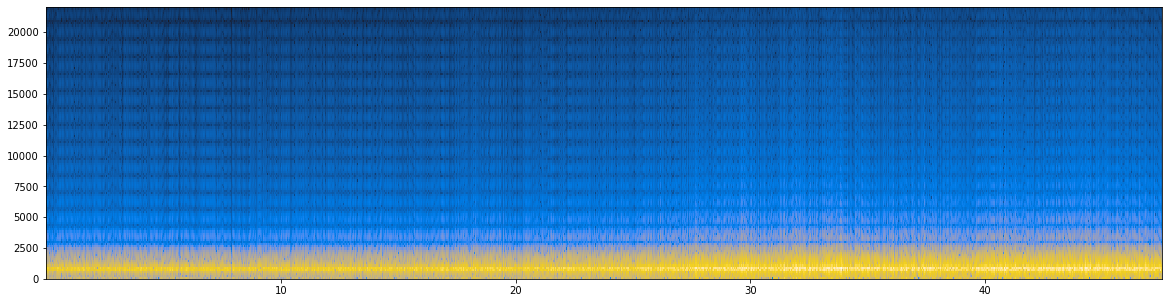

In [6]:
def plot_filtered_band(min_f, max_f):
    band_data = butter_bandpass_filter(data, lowcut=min_f, highcut=max_f, fs=fs, order=5)
    f, t, Sxx = signal.spectrogram(band_data, fs)
    plt.figure(figsize=(20, 5))
    plt.pcolormesh(t, f, Sxx, norm=matplotlib.colors.LogNorm(), cmap=cc.cm.CET_CBL2)#, vmax=max_useful_value)
    plt.show()
    return band_data  

bnd = plot_filtered_band(700, 900)


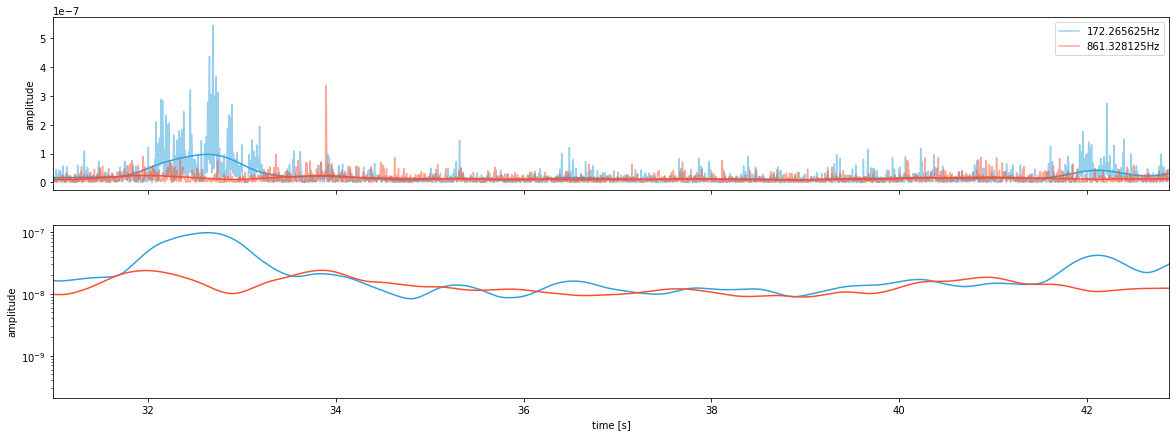

In [7]:
amp_peaks_idx = signal.find_peaks(freq_amplitude, height=10e-11)[0]

thresh = 0.018 # select peaks of volume for zooming
time_peaks_idx = signal.find_peaks(data_short, height=thresh)[0]
zoom_range = [np.min(t[time_peaks_idx]), np.max(t[time_peaks_idx])]
delta_range = zoom_range[1] - zoom_range[0]
zoom_range[0] -= delta_range/5
zoom_range[1] += delta_range/5


fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(20,7))
#axins = inset_axes(ax, width="60%", height="60%", loc=2)
ax2.set(yscale='log', #ylim=[10e-10, np.max(Sxx)], 
          xlim=[*zoom_range])
ax2.set(xlabel=('time [s]'), ylabel=('amplitude'))
ax1.set(ylabel=('amplitude'))


band_width = 10
for ip in amp_peaks_idx:
    band_color = get_col_peaks_freq_ampl(np.where(amp_peaks_idx==ip)[0][0])
    band_amplitude = np.average(filtered_array(f, t, Sxx, f[ip]-band_width/2, f[ip]+band_width/2)[2], axis=0)
    smooth_window = 2*100+1 # ~ 1 sec
    smoothed_amplitude = smooth(band_amplitude, window_len=smooth_window)[int((smooth_window-1)/2):-int((smooth_window-1)/2)]
    ax1.plot(t, band_amplitude, label=str(f[ip])+'Hz', alpha=0.5, c=band_color)
    ax1.plot(t, smoothed_amplitude, c=band_color)
    #axins.plot(t, band_amplitude, label=str(f[ip])+'Hz', alpha=0.5, c=band_color)
    ax2.plot(t, smoothed_amplitude, c=band_color)
    
ax1.legend()
plt.savefig('images/bands_'+filename.split('.')[0]+'.png', dpi=400)
plt.show()

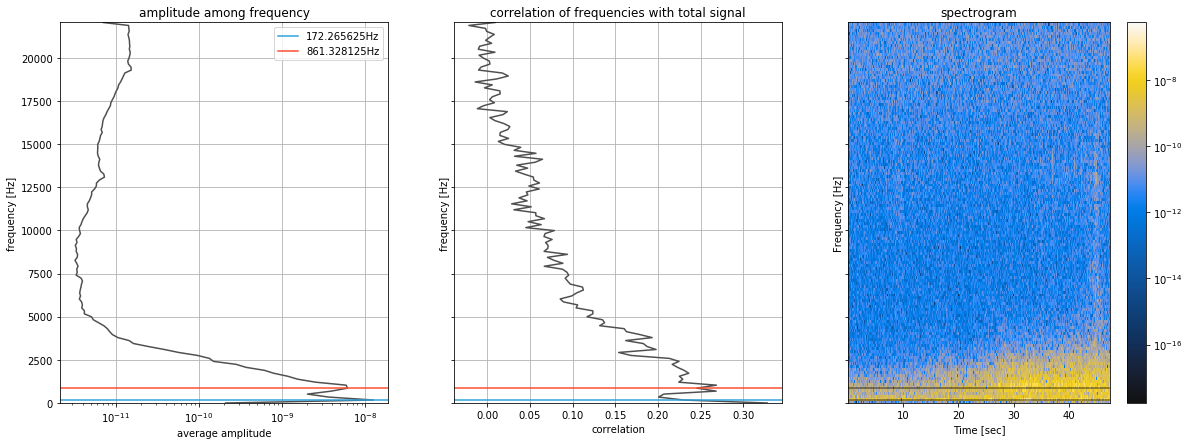

In [8]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(20,7))

ax0 = axs[0]
ax0.grid()
ax0.set(title='amplitude among frequency', ylabel='frequency [Hz]', xlabel='average amplitude', xscale='log')
ax0.plot(freq_amplitude, f, c='#505050')
for ip in amp_peaks_idx:
    band_color = get_col_peaks_freq_ampl(np.where(amp_peaks_idx==ip)[0][0])
    ax0.axhline(y=f[ip], xmin=0, xmax=1, c=band_color, label=str(f[ip])+'Hz')
    ax0.legend()
    #ax0.plot(t/60, smoothed_amplitude+f[ip], c=band_color)



ax1 = axs[1]
ax1.grid()
ax1.set(title='correlation of frequencies with total signal', ylabel='frequency [Hz]', xlabel='correlation')
correl = np.array([correlation_array(x, np.abs(data_short)) for x in Sxx])  #matmul(Sxx, data_short)/np.linalg.norm(Sxx, axis=1)
ax1.plot(correl, f, c='#505050')
for ip in amp_peaks_idx:
    band_color = get_col_peaks_freq_ampl(np.where(amp_peaks_idx==ip)[0][0])
    ax1.axhline(y=f[ip], xmin=0, xmax=1, c=band_color)


ax2 = axs[2]
ax2.set(title='spectrogram')

#plot_spectr(f, t, Sxx, log_scale=True, plot_params=(fig, ax2), vmax=max_useful_value, cmap='gist_gray')   
pcm = ax2.pcolormesh(t, f, Sxx, norm=matplotlib.colors.LogNorm(), cmap=cc.cm.CET_CBL2)#, vmax=max_useful_value)
fig.colorbar(pcm, ax=ax2)
ax2.set(ylabel='Frequency [Hz]', xlabel='Time [sec]')
for ip in amp_peaks_idx:
    band_color = get_col_peaks_freq_ampl(np.where(amp_peaks_idx==ip)[0][0])
    ax2.axhline(y=f[ip], xmin=0, xmax=1, c='black', alpha=0.5)

plt.savefig('images/spectrogram_'+filename.split('.')[0]+'.png', dpi=400)
plt.show()

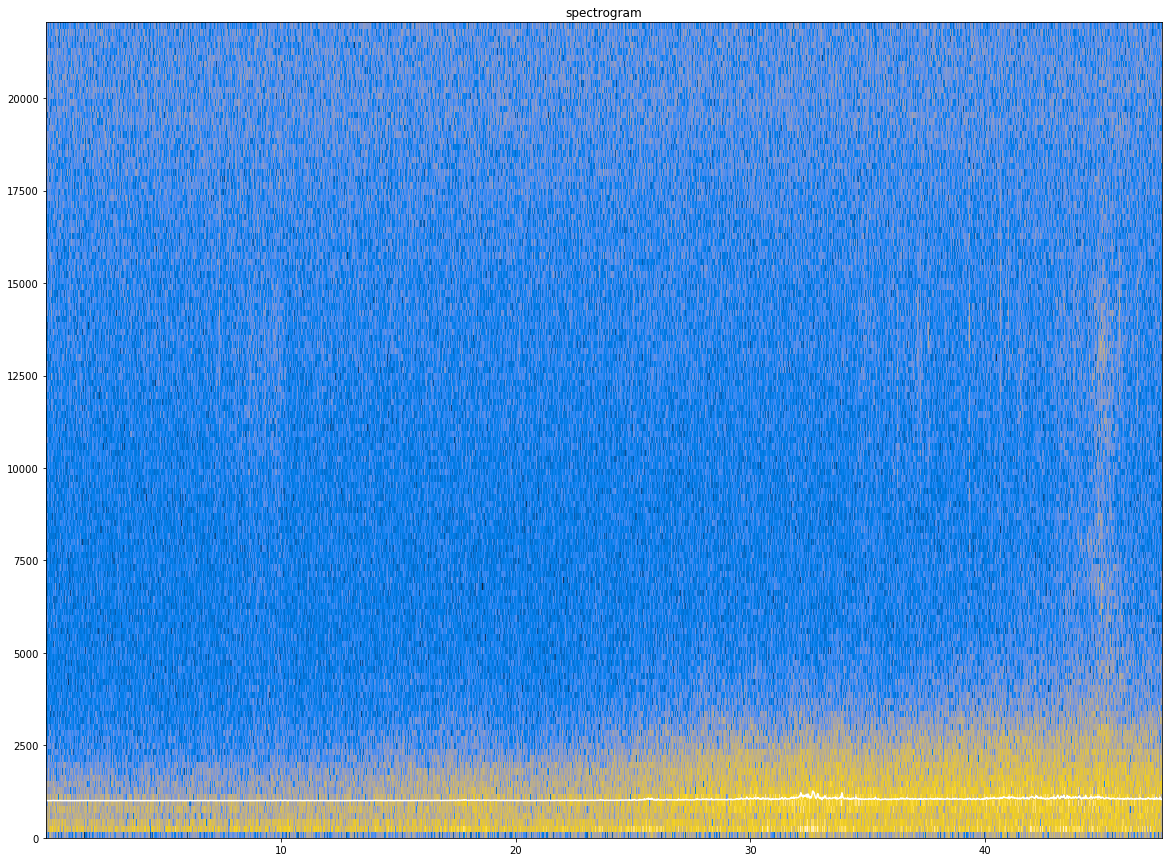

In [9]:
fig, axs = plt.subplots(figsize=(20,15))

ax = axs 

ax.set(title='spectrogram')
pcm = ax.pcolormesh(t, f, Sxx, norm=matplotlib.colors.LogNorm(), cmap=cc.cm.CET_CBL2)#, vmax=max_useful_value)
#ax.set(ylabel='Frequency [Hz]', xlabel='Time [sec]')
smooth_window = 11
ax.plot(t, smooth(np.average(Sxx, axis=0)*1.0e11, window_len=smooth_window)[int((smooth_window-1)/2):-int((smooth_window-1)/2)]+1000, c='#FFFFFF')

plt.show()